# <center>Project 03: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Nguyễn Bình An
- MSSV: 23127149    
- Lớp: 23CLC02

# Import

In [54]:
import pandas as pd
import numpy as np
import copy as cp
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu

In [55]:
# Đọc dữ liệu  bằng pandas
train = pd.read_csv('p03.train.csv')
test = pd.read_csv('p03.test.csv')



# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

X_train["Extracurricular Activities"] = X_train["Extracurricular Activities"].astype(int)
X_test["Extracurricular Activities"] = X_test["Extracurricular Activities"].astype(int)


# Cài đặt hàm

In [56]:
#Class for Linear Regression using OLS method
class SimpleOLSRegressor:
    def train(self, features, targets):
        """
        Train the OLS regression model.

        Parameters
        ----------
        features : numpy.ndarray
            2D array of feature values (without bias column).
        targets : array-like
            1D array of target values.

        Returns
        -------
        self : SimpleOLSRegressor
            Returns the fitted model.
        """
        features_ext = insert_bias_column(features)
        targets_arr = np.array(targets)
        pseudo_inv = np.matmul(
            np.linalg.inv(np.matmul(features_ext.T, features_ext)),
            features_ext.T
        )
        self.coefficients = np.matmul(pseudo_inv, targets_arr)
        return self
    
    def get_weights(self):
        """
        Get the learned weights of the model in formatted form.

        Returns
        -------
        numpy.ndarray
            Array of model coefficients including bias term.
        """
        np.set_printoptions(formatter={'float': lambda val: "{0:0.3f}".format(val)})
        return self.coefficients
    
    def forecast(self, features):
        """
        Predict target values given input features.

        Parameters
        ----------
        features : numpy.ndarray
            2D array of feature values (without bias column).

        Returns
        -------
        numpy.ndarray
            Predicted values.
        """
        features_ext = insert_bias_column(np.array(features))
        return np.sum(self.coefficients.ravel() * features_ext, axis=1)


# Class for performing K-Fold Cross Validation
class KFoldsEvaluator:
    def __init__(self, k_folds, dataset_parts, model_configs):
        """
        Initialize KFoldsEvaluator.

        Parameters
        ----------
        k_folds : int
            Number of folds for cross-validation.
        dataset_parts : list
            List of dataset partitions for each fold.
        model_configs : list
            List of model configurations (feature sets).
        """
        self.k_folds = k_folds
        self.dataset_parts = dataset_parts
        self.model_configs = model_configs
        self.model_labels = [extract_model_label(cfg) for cfg in model_configs]
        self.error_scores = dict.fromkeys(self.model_labels, 0)
        
    def execute(self):
        """
        Run k-fold cross-validation for all model configurations.
        """
        for part in self.dataset_parts:
            for cfg in self.model_configs:
                X_part = part[cfg]
                y_part = part['Performance Index']
                reg = SimpleOLSRegressor().train(X_part, y_part)
                predictions = reg.forecast(X_part)
                score = mae(y_part, predictions)
                self.error_scores[extract_model_label(cfg)] += score
    
    def _avg_errors(self):
        """
        Compute average error across folds for each model.
        """
        for label in self.model_labels:
            self.error_scores[label] /= self.k_folds
            
    def get_error_table(self):
        """
        Get a DataFrame containing average MAE for each model.

        Returns
        -------
        pandas.DataFrame
            Table with columns ['Model', 'MAE'].
        """
        pd.set_option('display.max_colwidth', None)
        self._avg_errors()
        results = []
        for label in self.model_labels:
            results.append([label, self.error_scores[label]])
        return pd.DataFrame(results, columns=['Model', 'MAE'])
        
    def get_optimal_model(self):
        """
        Get the label of the model with the lowest MAE.

        Returns
        -------
        str
            Label of the best-performing model.
        """
        best_label = min(self.error_scores, key=lambda lbl: self.error_scores[lbl])
        return [col.strip() for col in best_label.split(",")]
    

def insert_bias_column(matrix):
    """
    Add a bias (intercept) column of ones to the feature matrix.

    Parameters
    ----------
    matrix : numpy.ndarray
        Feature matrix without bias column.

    Returns
    -------
    numpy.ndarray
        Feature matrix with bias column added.
    """
    return np.concatenate((np.ones((matrix.shape[0], 1)), matrix), axis=1)

def generate_k_folds(df, k, model_cfgs):
    """
    Shuffle and split the dataset into k folds.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataset.
    k : int
        Number of folds.
    model_cfgs : list
        List of model configurations (feature sets).

    Returns
    -------
    list of pandas.DataFrame
        List containing k dataset splits.
    """
    data_copy = df.copy(deep=True)
    folds = []
    total_rows = len(df)
    fold_size = np.round(total_rows / k)
    
    data_copy = data_copy.sample(frac=1)
    cfg_copy = cp.deepcopy(model_cfgs)
    all_cols = list(set(np.concatenate(cfg_copy).flat))
    
    for i in range(k):
        folds.append(
            data_copy.iloc[int(i*fold_size):int(min(i*fold_size+fold_size, total_rows))][all_cols + ['Performance Index']]
        )
    return folds


def extract_model_label(config):
    """
    Convert a model configuration list to a human-readable label.

    Parameters
    ----------
    config : list of str
        Feature names.

    Returns
    -------
    str
        Comma-separated feature names.
    """
    return ', '.join(config) if len(config) > 1 else config[0]


def mae(true_vals, pred_vals):
    """
    Calculate Mean Absolute Error (MAE).

    Parameters
    ----------
    true_vals : array-like
        Actual target values.
    pred_vals : array-like
        Predicted target values.

    Returns
    -------
    float
        Mean Absolute Error value.
    """
    return np.mean(np.abs(np.array(true_vals).ravel() - np.array(pred_vals).ravel()))

def plot_heatmap(train: pd.DataFrame) -> None:
    """
    Plot a heatmap showing correlations between features 
    (excluding the first and last columns).

    Parameters:
        train (pd.DataFrame): Training dataset.
    """
    train_corr = train.corr()
    ones_corr = np.ones_like(train_corr, dtype=bool)
    mask = np.triu(ones_corr)
    
    train_corr = train_corr.iloc[1:, :-1]
    mask = mask[1:, :-1]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
    sns.heatmap(
        data=train_corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        linecolor='white',
        linewidths=0.5,
        vmax=1,
        vmin=-1
    )
    plt.title("Feature Heatmap", fontsize=16)
    plt.show()


def plot_histograms(train: pd.DataFrame) -> None:
    """
    Plot histograms for all features.

    Parameters:
        train (pd.DataFrame): Training dataset.
    """
    train.hist(figsize=(12, 8), bins=15, edgecolor='black')
    plt.suptitle("Feature Histograms", fontsize=16)
    plt.show()


def plot_boxplots(train: pd.DataFrame) -> None:
    """
    Plot boxplots for all numerical features.

    Parameters:
        train (pd.DataFrame): Training dataset.
    """
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=train.select_dtypes(include=['int64', 'float64']))
    plt.title("Feature Boxplots")
    plt.show()


def plot_scatter_vs_target(train: pd.DataFrame, target: str) -> None:
    """"
    Plot scatter plots between each feature and the target variable.

    Parameters:
        train (pd.DataFrame): Training dataset.
        target (str): Name of the target column.
    """
    features = train.columns[:-1]
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(features, 1):
        plt.subplot(2, 3, i)
        sns.scatterplot(x=col, y=target, data=train)
        plt.title(f"{col} vs {target}")
    plt.tight_layout()
    plt.show()


def plot_rolling_mean(train: pd.DataFrame, window_size: int = 50) -> None:
    """
    Plot rolling mean trends for each feature.

    Parameters:
        train (pd.DataFrame): Training dataset.
        window_size (int): Number of data points for calculating the rolling mean.
    """
    train_rolling = train.rolling(window=window_size).mean()
    plt.figure(figsize=(12, 6))
    for col in train.columns:
        plt.plot(train_rolling.index, train_rolling[col], linewidth=1.5, label=col)
    plt.title(f"Feature Trends (Rolling Mean over {window_size} points)")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


def descriptive_statistics(train: pd.DataFrame) -> None:
    """
    Print descriptive statistics, variance, skewness, and kurtosis for all features.

    Parameters:
        train (pd.DataFrame): Training dataset.
    """
    stats = train.describe()
    print("📊 Descriptive statistics of features:")
    print(stats)
    print("\n📈 Variance of each feature:")
    print(train.var())
    print("\n📉 Skewness of each feature:")
    print(train.skew())
    print("\n📌 Kurtosis of each feature:")
    print(train.kurt())

*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu

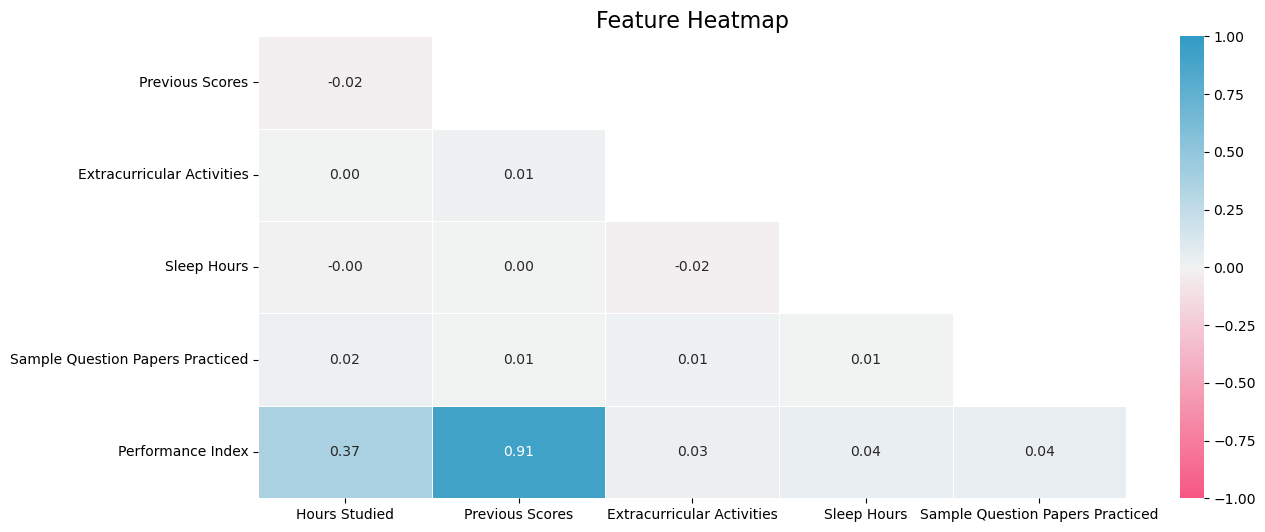

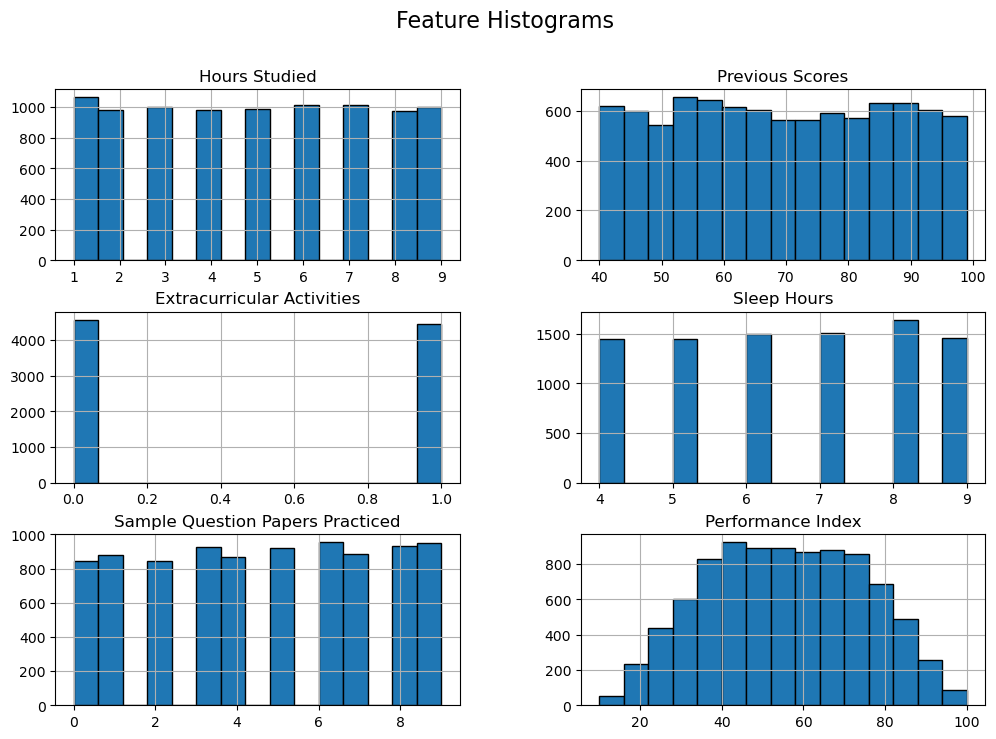

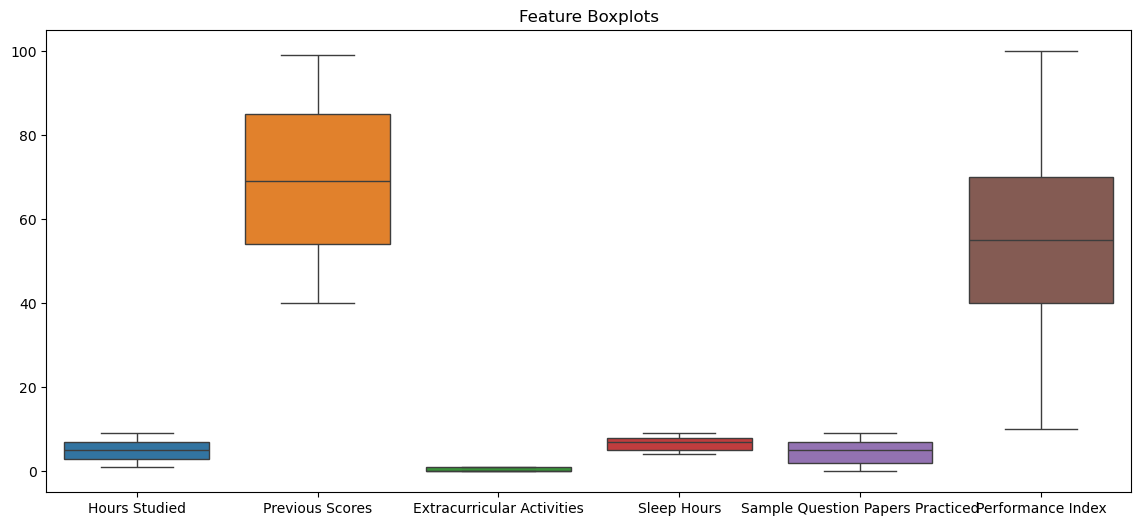

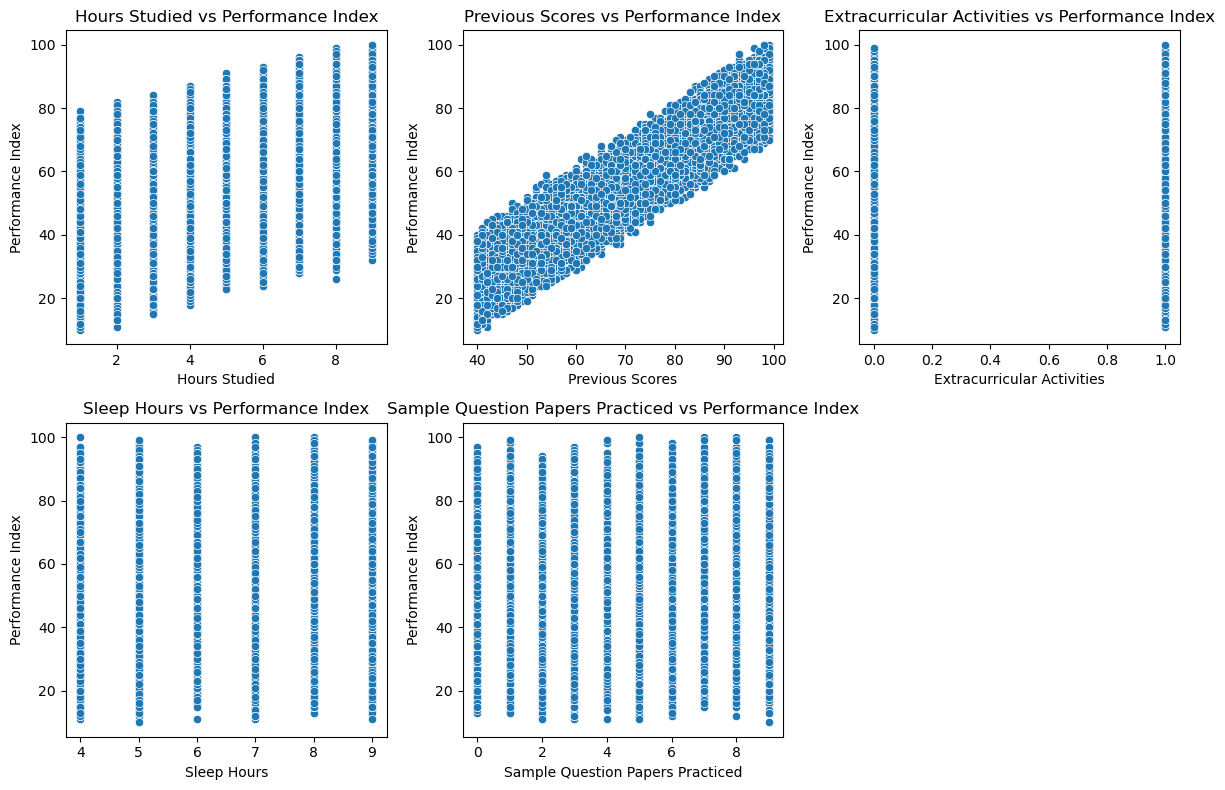

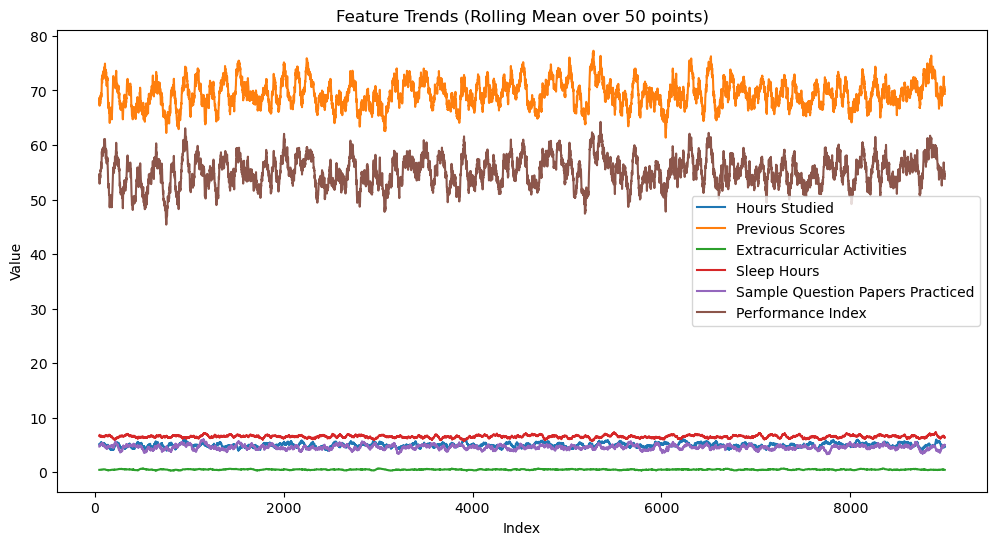

📊 Descriptive statistics of features:
       Hours Studied  Previous Scores  Extracurricular Activities  \
count    9000.000000      9000.000000                 9000.000000   
mean        4.976444        69.396111                    0.493667   
std         2.594647        17.369957                    0.499988   
min         1.000000        40.000000                    0.000000   
25%         3.000000        54.000000                    0.000000   
50%         5.000000        69.000000                    0.000000   
75%         7.000000        85.000000                    1.000000   
max         9.000000        99.000000                    1.000000   

       Sleep Hours  Sample Question Papers Practiced  Performance Index  
count  9000.000000                       9000.000000        9000.000000  
mean      6.535556                          4.590889          55.136333  
std       1.695533                          2.864570          19.187669  
min       4.000000                          

In [57]:
plot_heatmap(train)
plot_histograms(train)
plot_boxplots(train)
plot_scatter_vs_target(train, "Performance Index")
plot_rolling_mean(train, window_size=50)
descriptive_statistics(train)

# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp

In [58]:
# Phần code cho yêu cầu 2a
X_train_2a = cp.deepcopy(X_train).iloc[:,:11]

# Tính toán mô hình cho 5 đặc trưng đầu tiên
lr_2a = SimpleOLSRegressor().train(X_train_2a, y_train)
lr_2a.get_weights()

array([-33.969, 2.852, 1.018, 0.604, 0.474, 0.192])

In [59]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
X_test_2a = X_test.iloc[:,:11]

y_hat_2a = lr_2a.forecast(X_test_2a)
print("MAE: ", mae(y_hat_2a, y_test))

MAE:  1.595648688476294


Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -33.969 + 2.852*\text{Hours Studied} + 1.018*\text{Previous Scores} + 0.604*\text{Extracurricular Activities} \\
+ 0.474*\text{Sleep Hours} + 0.192*\text{Sample Question Papers Practiced}$$

# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [60]:
# Phần code cho yêu cầu 2b
# Tìm ra đặc trưng tốt nhất (trong 5 đặc trưng)
# In ra các kết quả cross-validation như yêu cầu
models_2b = [
    ['Hours Studied'],
    ['Previous Scores'],
    ['Extracurricular Activities'],
    ['Sleep Hours'],
    ['Sample Question Papers Practiced']
]
num_folds = 5  
folds_for_eval_2b = generate_k_folds(train, num_folds, models_2b)

fold_evaluator_2b = KFoldsEvaluator(num_folds, folds_for_eval_2b, models_2b)
fold_evaluator_2b.execute()

best_feature = fold_evaluator_2b.get_optimal_model()
print("Best feature:", best_feature)

fold_evaluator_2b.get_error_table()


Best feature: ['Previous Scores']


,Model,MAE
0,Hours Studied,15.438028
1,Previous Scores,6.615449
2,Extracurricular Activities,16.183057
3,Sleep Hours,16.172788
4,Sample Question Papers Practiced,16.171361


In [61]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_train_2b = cp.deepcopy(X_train)[best_feature]

lr_2b = SimpleOLSRegressor().train(X_train_2b, y_train)
lr_2b.get_weights()

array([-14.989, 1.011])

In [62]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_feature_model
X_test_2b = X_test[best_feature]

y_hat_2b = lr_2b.forecast(X_test_2b)
print("MAE of best_feature_model: ", mae(y_hat_2b, y_test))

MAE of best_feature_model:  6.544277293452504


Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -14.989 + 1.011*\text{Previous Scores}$$

# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất

## Xây dựng/Thiết kế mô hình

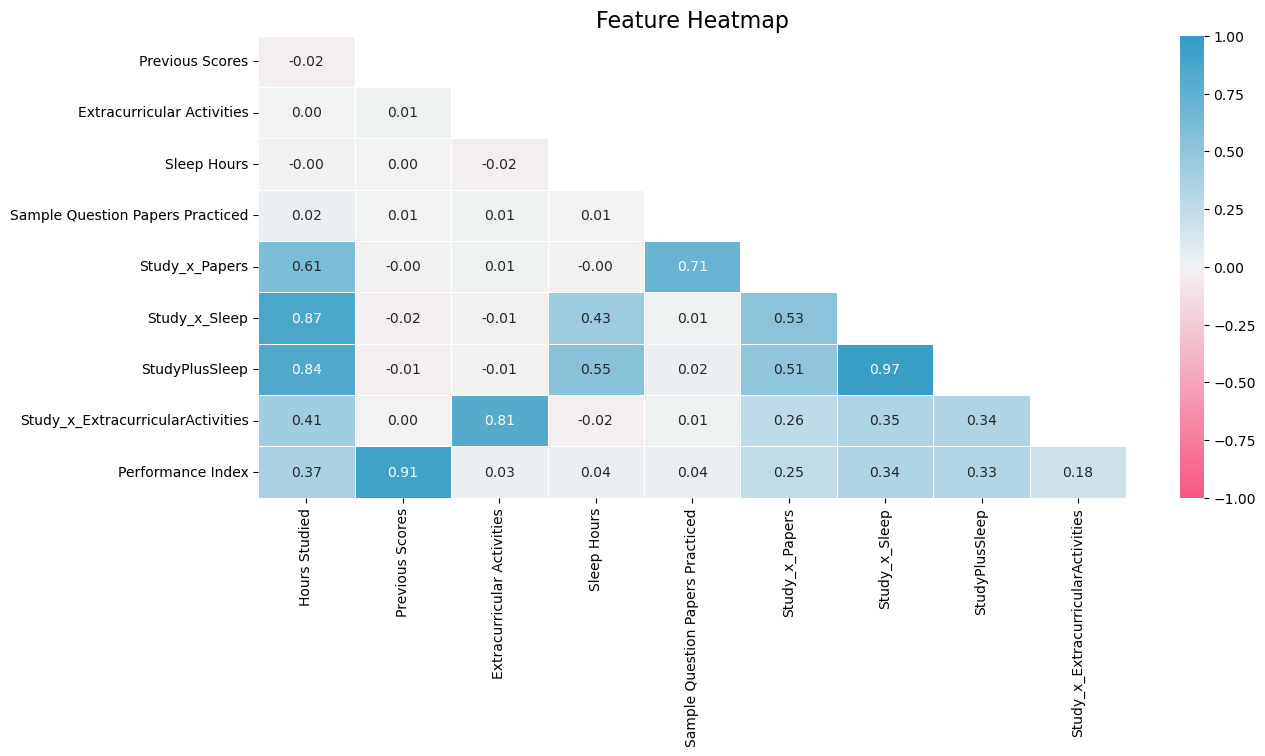

In [63]:
def add_custom_features(df):
    df['Study_x_Papers'] = df['Hours Studied'] * df['Sample Question Papers Practiced']
    
    df['Study_x_Sleep'] = df['Hours Studied'] * df['Sleep Hours']
    
    df['StudyPlusSleep'] = df['Hours Studied'] + df['Sleep Hours']
    
    df['Study_x_ExtracurricularActivities'] = df['Hours Studied'] * df['Extracurricular Activities']
    
    if 'Performance Index' in df.columns:
        perf_col = df.pop('Performance Index')
        df['Performance Index'] = perf_col
        
    return df

train_2c = add_custom_features(train)
plot_heatmap(train_2c)

model_2c = []
# Mô hình 1: 6 đặc trưng
model_2c.append(["Hours Studied", "Previous Scores", "Study_x_Papers", "Study_x_Sleep", "StudyPlusSleep", "Study_x_ExtracurricularActivities"])
# Mô hình 2: 5 đặc trưng 
model_2c.append(["Hours Studied", "Previous Scores", "Study_x_Papers", "Study_x_Sleep", "Study_x_ExtracurricularActivities"])
# Mô hình 3: 4 đặc trưng
model_2c.append(["Hours Studied", "Previous Scores", "Study_x_Papers", "Study_x_ExtracurricularActivities"])



## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

In [64]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu

num_folds = 5  
folds_for_eval_2c = generate_k_folds(train, num_folds, model_2c)

fold_evaluator_2c = KFoldsEvaluator(num_folds, folds_for_eval_2c, model_2c)

fold_evaluator_2c.execute()

best_model = fold_evaluator_2c.get_optimal_model()
print("Best model:", best_model)

fold_evaluator_2c.get_error_table()


Best model: ['Hours Studied', 'Previous Scores', 'Study_x_Papers', 'Study_x_Sleep', 'StudyPlusSleep', 'Study_x_ExtracurricularActivities']


,Model,MAE
0,"Hours Studied, Previous Scores, Study_x_Papers, Study_x_Sleep, StudyPlusSleep, Study_x_ExtracurricularActivities",1.629296
1,"Hours Studied, Previous Scores, Study_x_Papers, Study_x_Sleep, Study_x_ExtracurricularActivities",1.650031
2,"Hours Studied, Previous Scores, Study_x_Papers, Study_x_ExtracurricularActivities",1.752523


In [65]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
X_train_2c = cp.deepcopy(train)[best_model]

lr_2c = SimpleOLSRegressor().train(X_train_2c, y_train)
lr_2c.get_weights()

array([-32.624, 2.178, 1.018, 0.031, 0.005, 0.448, 0.102])

In [66]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
test = add_custom_features(test)

X_test = test.iloc[:, :-1] 
X_test_2c = X_test[best_model]

y_hat_2c = lr_2c.forecast(X_test_2c)
print("MAE of best_feature_model: ", mae(y_hat_2c, y_test))

MAE of best_feature_model:  1.613738820479369


Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -32.624 + 2.178* \text{Hours Studied} + 1.018* \text{Previous Scores}\\
 + 0.031 * \text{Study\_x\_Papers} + 0.005 * \text{Study\_x\_Sleep} +  0.448* \text{StudyPlusSleep} \\
 + 0.102 * \text{Study\_x\_ExtracurricularActivities} $$